#  Final Project for the Python for Spectroscopy Workshop
## Adapted by Chandru using Astropy Specutils & STSci JWST Toolset

![Specutils: An Astropy Package for Spectroscopy](spec_analysis/specutils_logo.png)

This notebook is intended for live-coding during the Python for Spectroscopy workshop. You should only do this if you feel comfortable trying to keep up! If you'd rather have an already-populated solution notebook, go to [final_project_p4s.ipynb](spec_analysis/final_project_p4s.ipynb) instead, which you can execute as we go.

#  Import Required Libraries & Packages

In [1]:
import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file

import specutils
from specutils import Spectrum1D, SpectralRegion, analysis, manipulation, fitting
specutils.__version__

'1.15.0'

In [2]:
# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt


# for showing quantity units on axes automatically:
from astropy.visualization import quantity_support
quantity_support();

# Fundamentals of specutils (skip if you are already familiar)

## Objects for representing spectra

The most fundamental purpose of `specutils` is to contain the shared Python-level data structures for storing astronomical spectra.  It is important to recognize that this is not the same as the *on-disk* representation.  As desecribed later specutils provides loaders and writers for various on-disk representations, with the intent that they all load to a common set of in-memory/Python interfaces.  Those intefaces (implemented as Python classes) are described in detail in the [relevant section of the documentation](https://specutils.readthedocs.io/en/latest/types_of_spectra.html), which contains this diagram:

![Specutils Classes](spec_analysis/specutils_classes_diagrams.png)

The core principal is that all of these representations contain a `spectral_axis` attribute as well as a `flux` attribute (as well as optional matching `uncertainty`).  The former is often wavelength for OIR spectra, but might be frequency or energy for e.g. Radio or X-ray spectra.  Regardless of which spectral axis is used, the class attempts to interpret it appropriately, using the features of `astropy.Quantity` to distinguish different types of axes.  Similarly, `flux` may or may not be a traditional astronomical `flux` unit (e.g. Jy or  erg sec$^{-1}$ cm$^{-2}$ angstrom$^{-1}$), but is treated as the portion of the spectrum that acts in that manner.  The various classes are then distinguished by whether these attributes are one-dimensional or not, and how to map the `spectral_axis` dimensionality onto the `flux`.  The simplest case (and the one primarily considered here) is the scalar `Spectrum1D` case, which is a single spectrum with a matched-size `flux` and `spectral_axis`.

## Basics of creating Spectrum1D Objects

If your spectrum is in a format that specutils understands, loading it is very straightforward.  There are times when you want a bit more control, though, so lets look at loading from a file and creating an object directly from arrays:

## Loading spectra from files

Specutils comes with readers for a variety of spectral data formats (including loaders for future JWST instruments). While support for specific formats depends primarily from users (like you!) providing readers, you may find that one has already been implemented for your favorite spectrum format.  As an example, we consider a simulated high-redshift (z > 1) galaxy like that you might see from NIRSpec:

In [3]:
url_to_download = 'https://stsci.box.com/shared/static/b22b1fzhimtdqfp8597m4bg67kovvauu.fits'

In [4]:
from astropy.utils.data import download_file

spec_fn = download_file(url_to_download, cache=True)
spec_fn

'/home/jupyter-chandru.narayan.p4-65095/.astropy/cache/download/url/cda1d30009641d0a2739c2f5198a3f41/contents'

To see the full list of formats readable in your current version of specutils, see the table at the bottom of the `Spectrum1d.read` method:

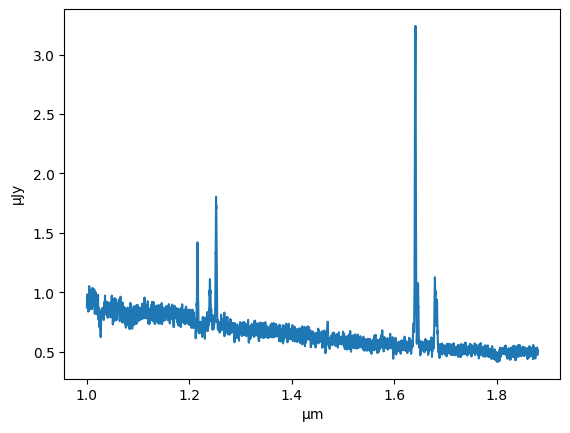

In [5]:
sample_spec = Spectrum1D.read(spec_fn)
sample_spec
plt.plot(sample_spec.spectral_axis, sample_spec.flux)

In [6]:
help(Spectrum1D.read)

Help on NDDataRead in module astropy.nddata.mixins.ndio object:

class NDDataRead(astropy.io.registry.interface.UnifiedReadWrite)
 |  NDDataRead(instance, cls)
 |  
 |  Read and parse gridded N-dimensional data and return as an NDData-derived
 |  object.
 |  
 |  This function provides the NDDataBase interface to the astropy unified I/O
 |  layer.  This allows easily reading a file in the supported data formats,
 |  for example::
 |  
 |    >>> from astropy.nddata import CCDData
 |    >>> dat = CCDData.read('image.fits')
 |  
 |  Get help on the available readers for ``CCDData`` using the``help()`` method::
 |  
 |    >>> CCDData.read.help()  # Get help reading CCDData and list supported formats
 |    >>> CCDData.read.help('fits')  # Get detailed help on CCDData FITS reader
 |    >>> CCDData.read.list_formats()  # Print list of available formats
 |  
 |  For more information see:
 |  
 |  - https://docs.astropy.org/en/stable/nddata
 |  - https://docs.astropy.org/en/stable/io/unified.ht

# Create a JWST Spectrum1D object from Dave Decker spectra

## Download fits images and spectra

In [35]:
# Only use this if files are locally available on JupyterHub
fits_fn = 'dave_decker_spectral_images/Calibrated_1D_Spectra/Arcturus_DaveDecker_2024-06-28_CALIB.fit'
#fits_fn = 'dave_decker_spectral_images/Calibrated_1D_Spectra/Antares_DaveDecker_2024-07-01_CALIB.fit'
imag_fn = 'dave_decker_spectral_images/Stacked Data Files/Alf Boo-Comp_stacked.fit'
#imag_fn = 'dave_decker_spectral_images/Stacked Data Files/Antares_stacked.fit'
fitsfile = fits.open(fits_fn)
fitsfile.info()
imagfile = fits.open(imag_fn)
imagfile.info()
fitsfile.close()

Filename: dave_decker_spectral_images/Calibrated_1D_Spectra/Arcturus_DaveDecker_2024-06-28_CALIB.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (3096,)   float32   
Filename: dave_decker_spectral_images/Stacked Data Files/Alf Boo-Comp_stacked.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (3096, 2080)   float32   


In [37]:
# Only use this if files are available on Chandru's website below
fits_url_to_download = 'http://chandrunarayan.com/boyce_astro/dave_decker_spectral_images/Calibrated_1D_Spectra/Arcturus_DaveDecker_2024-06-28_CALIB.fit'
#fits_url_to_download = 'http://chandrunarayan.com/boyce_astro/dave_decker_spectral_images/Calibrated_1D_Spectra/Antares_DaveDecker_2024-07-01_CALIB.fit'
imag_url_to_download = 'http://chandrunarayan.com/boyce_astro/dave_decker_spectral_images/Stacked Data Files/Alf Boo-Comp_stacked.fit'
#imag_url_to_download = 'http://chandrunarayan.com/boyce_astro/dave_decker_spectral_images/Stacked Data Files/Antares_stacked.fit'
fits_url_to_download = fits_url_to_download.replace(" ", "%20")
imag_url_to_download = imag_url_to_download.replace(" ", "%20")
fits_fn = download_file(fits_url_to_download, cache=True)
imag_fn = download_file(imag_url_to_download, cache=True)
fitsfile = fits.open(fits_fn)
fitsfile.info()
imagfile = fits.open(imag_fn)
imagfile.info()

Filename: /home/jupyter-chandru.narayan.p4-65095/.astropy/cache/download/url/94741bb12a611d6383696fdae2d2ab79/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (3096,)   float32   
Filename: /home/jupyter-chandru.narayan.p4-65095/.astropy/cache/download/url/b5da20ac6b298db608d7593808a78290/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (3096, 2080)   float32   


## Examine Headers & Plot Data - determine any offsets

This will show Specviz inline in the notebook. You can pass an integer to the `height` keyword to change the displayed height of the app (the default is 600). You can also pass `loc=\"popout:window\"` to immediately pop out the Jdaviz app into a separate window.

In [9]:
from jdaviz import Specviz
specviz = Specviz()

In [10]:
#specviz.show()
#specviz.show(loc="sidecar")

In [11]:
#specviz.load_data(cust_spec1d)

In [12]:
myhdr = fitsfile[0].header
myhdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =                 3096 / length of data axis 1                          
CRPIX1  =                    475 / Reference pixel                              
CDELT1  =       9.15056952998788 / Coordinate increment                         
CRVAL1  =       307.345543151757 / Coordinate at reference pixel                
CTYPE1  = 'Wavelength'           / Axis Type                                    
CUNIT1  = 'Angstrom'             / Wavelength unit                              
SWCREATE= 'RSpec 2.1.1.18'                                                      
VERSION = 'RSpec 2.1.1.18'                                                      
OBSERVER= 'DDGB'                                                                
BSS_SITE= 'La Mesa'         

In [13]:
mydat = fitsfile[0].data
mydat

array([ 0.      ,  0.      ,  0.      , ..., 24.909164, 23.954582,
       23.954582], dtype='>f4')

In [14]:
flux = mydat*u.count
print(flux)
print(len(flux))
print(max(flux))
print(np.argmax(flux))

[ 0.        0.        0.       ... 24.909164 23.954582 23.954582] ct
3096
6685.84619140625 ct
441


In [15]:
raw_pixels = np.arange(3096)*u.pixel
offset_pixels = (np.arange(3096) - np.argmax(flux))*u.pixel

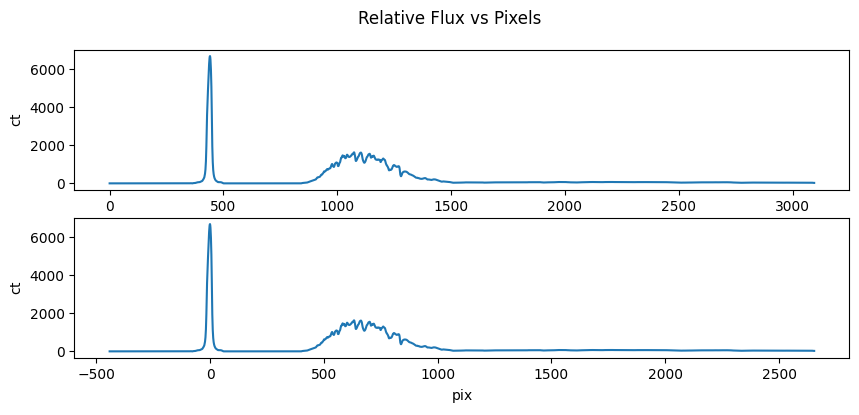

In [16]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 4))
fig.suptitle('Relative Flux vs Pixels')
ax1.plot(raw_pixels, flux)
ax2.plot(offset_pixels, flux)

## Create a Spectrum1D object for passing to Specviz

This will show Specviz inline in the notebook. You can pass an integer to the `height` keyword to change the displayed height of the app (the default is 600). You can also pass `loc=\"popout:window\"` to immediately pop out the Jdaviz app into a separate window.

In [17]:
wavelength = raw_pixels
arcturus_spec1d_raw = Spectrum1D(spectral_axis=wavelength,flux=flux)
wavelength = offset_pixels
arcturus_spec1d_off = Spectrum1D(spectral_axis=wavelength,flux=flux)

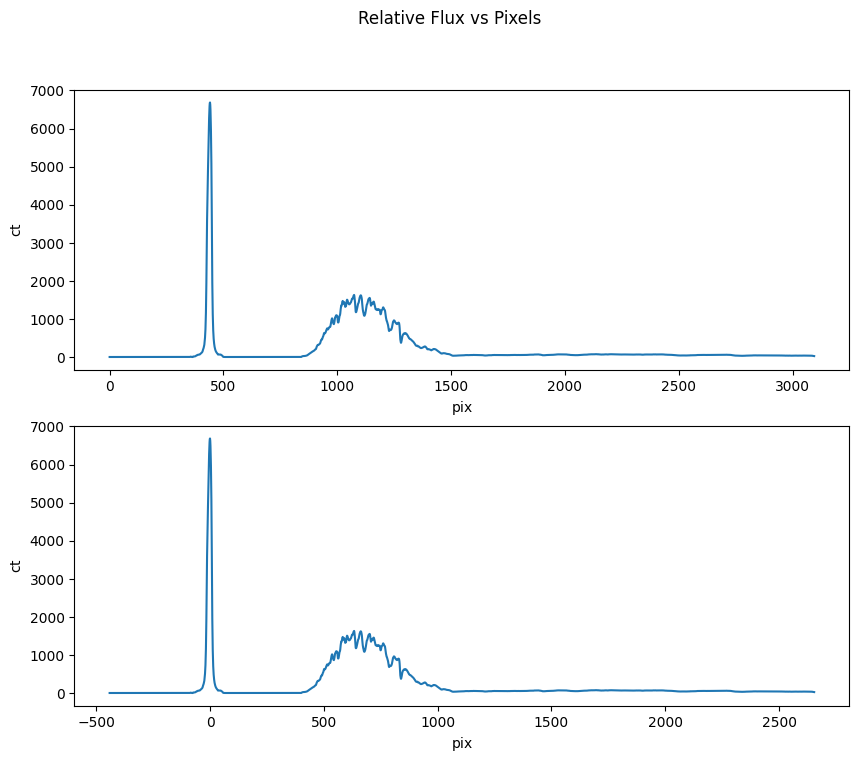

In [18]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 8))
fig.suptitle('Relative Flux vs Pixels')
ax1.plot(arcturus_spec1d_raw.spectral_axis, arcturus_spec1d_raw.flux)
ax2.plot(arcturus_spec1d_off.spectral_axis, arcturus_spec1d_off.flux)

In [19]:
#specviz.show(loc="sidecar")
specviz.show(loc="sidecar")
#specviz.load_data(arcturus_spec1d_raw)
#specviz.load_data(arcturus_spec1d_off)

In [20]:
app = 6562.8/(1348-756)
pix_ang = [
   (u.pixel, u.Angstrom, lambda x: (x - np.argmax(flux))*app, lambda x: x/app+np.argmax(flux))
]
u.pixel.to(u.Angstrom, 1636, equivalencies=pix_ang)

13247.543918918918

In [21]:
hyd_alp_prf_wl = 1348*u.pixel
hyd_alp_ref_wl = 6562.8*u.Angstrom
unk_prf_wl = 1636*u.pixel
print(f'hyd alp std wl = {hyd_alp_ref_wl.to(u.Angstrom, equivalencies=pix_ang)} & pixels = {hyd_alp_prf_wl}')
print(f'unk cal wl = {unk_prf_wl.to(u.Angstrom, equivalencies=pix_ang)}')

hyd alp std wl = 6562.8 Angstrom & pixels = 1348.0 pix
unk cal wl = 13247.543918918918 Angstrom


In [22]:
raw_pixels = np.arange(3096)*u.pixel
wavelength = raw_pixels.to(u.Angstrom, equivalencies=pix_ang)
wavelength
arcturus_spec1d_calib = Spectrum1D(spectral_axis=wavelength,flux=flux)
arcturus_spec1d_calib

<Spectrum1D(flux=[0.0 ... 23.95458221435547] ct (shape=(3096,), mean=227.89162 ct); spectral_axis=<SpectralAxis [-4888.84256757 -4877.75675676 -4866.67094595 ... 29399.57027027
 29410.65608108 29421.74189189] Angstrom> (length=3096))>

In [23]:
specviz.load_data(arcturus_spec1d_calib)

# Arithmetic on Spectra

Specutils provides a lot of functionality for manipulating spectra.  In general these follow the pattern of creating *new* specutils objects with the results of the operation instead of in-place operations.

The most straightforward of operations are arithmetic manipulations.  In general these follow patterns that are based on fundametal arithmetic. E.g.:

However, when there is ambiguity in your intent - for example, two spectra with different units where it is not clear what the desired output is - errors are generally produced instead of the code attempting to guess:

Resolving this requires explicit conversion:

### Exercises

1. Try continuum *normalizing* using the above assumed continuum level, instead of subtracting. 
2. You can tell by-eye that the continuum isn't a flat level, but has a slope to it.  Try subtracting a *sloping* continuum instead of a single value (it's fine to just estimate it by-eye, fancier continuum subtracting will come later).

## SNR and Uncertainties

Now lets try a simple calculation: the S/N of this spectrum. While pipeline-output JWST files will have uncertainties, for this example we are using a basic simulation without the uncertainities. Hence we start using an SNR estimate that follows a [straightforward algorithm detailed in the literature](https://www.stecf.org/software/ASTROsoft/DER_SNR/).

That's straightforward enough, but does not use any uncertainty information beyond the spectrum itself. To mock up what real JWST might look like (or how you would provide your *own* uncertainties), we can create a new Spectrum1D object with by-hand added uncertainties:

After that, it is a one-liner to compute the S/N directly, which will use the uncertainty already in the spectrum: